# Proyecto 04 - Sistemas de Recomendación para la Plataforma STEAM

## Dataset: STEAM

Link [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.


# **Objetivo:**

Mejorar un modelo de machine learning de Filtro Colaborativo para un Sistema de Recomendación de juegos de las plataforma STEAM. 
Después de realizar la combinación de los datasets, se ampliará el análisis exploratorio de la columna "Text" con métodos de NPL para clasificar dicha variable en comentarios positivos o negativos y en base a ella determinar si existe la posibilidad de mejorar las predicciones. 

A continuación, el link al repositorio GitHub: https://github.com/aldykarina/Proyecto03_Sistemas_de_Recomendaci-n.git

## **Exploración de datos**

### **Librerías**

In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import LabelEncoder

import itertools
import nltk
nltk.download('punkt')
nltk.download('stopwords')

def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### **Abrir los archivos**

Abrimos el archivo json, creamos un nuevo archivo pasandolo csv y lo guardamos.



**Reviews**

Con este codigo solo tomamos una decima parte del dataset original para no colapsar la memoria RAM.
Y lo guardamos como archivo csv.

In [3]:
#contador = 0
#data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.

#n = 10
#for l in parse('/content/gdrive/MyDrive/Colab Files/steam_reviews.json.gz'):
#    if contador%n == 0:
#        data_reviews.append(l)
#    else:
#        pass
#    contador += 1
#data_reviews = pd.DataFrame(data_reviews)
#data_reviews.to_csv('/content/gdrive/MyDrive/Colab Files/data_reviews.csv',index=False)

In [4]:
data_reviews = pd.read_csv('/content/gdrive/MyDrive/Colab Files/data_reviews.csv')
#data_reviews= pd.DataFrame(data_reviews, columns=['username', 'product_id', 'text'])

**Games**

In [5]:
#data_games = []
#for l in parse('/content/gdrive/MyDrive/Colab Files/steam_games.json.gz'):
#    data_games.append(l)
#data_games = pd.DataFrame(data_games) 
#data_games.to_csv('/content/gdrive/MyDrive/Colab Files/data_games.csv',index=False)


In [6]:
data_games = pd.read_csv('/content/gdrive/MyDrive/Colab Files/data_games.csv')

In [7]:
#data_games= pd.DataFrame(data_games, columns=['title', 'id'])

### **Reviews**

In [8]:
print(f'Nº de filas: {data_reviews.shape[0]}')
print(f'Nº de columnas: {data_reviews.shape[1]}')

Nº de filas: 779307
Nº de columnas: 12


In [9]:
data_reviews.head()

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN
2,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN
3,The_Cpt_FROGGY,7.8,2217.0,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1,7.656120e+16,Product received for free,NaN
4,the_maker988,8.2,18.0,35140,7,2018-01-02,"This game was way to linear for me, and compar...",False,1,7.656120e+16,NaN,NaN


**Data Reviews**: contiene información sobre las reseñas que realizaron los usuarios sobre los juegos que bajaron de la plataforma. A continuación describiremos sus principales características:


*   **username**: nombre del usuario
*   **hours** horas que ese usuario ha jugado ese juego
*   **products**: cantidad de productos que el usuario compro en la plataforma
*   **product_id**: identificacion numerica y única del juego
*   **date**: fecha en que el usuario realizó la reseña
*   **text**: texto con observaciones del usuario
*   **found_funny** las reseñas que realiza el usuario pueden ser marcadas como "funnys" por otros usuarios. Este indicador numerico es la cantidad de "calificaciones funny" que su reseña obtuvo. Es importante señalar que las reseñas que el usuario realiza solo puede calificarlas con "dedito arriba" o "dedito abajo". 

    


Evitamos que los product_id aparezcan con notación cientrífica


In [10]:
pd.options.display.float_format = '{:.1f}'.format

Miramos las principales estadísticas de las variables numéricas

In [11]:
data_reviews.describe()

,hours,products,product_id,page_order,page,user_id,found_funny
count,776670.0,777741.0,779307.0,779307.0,779307.0,317340.0,120164.0
mean,111.8,237.0,251489.8,4.4,893.6,76561198096636224.0,7.7
std,390.1,486.0,149975.4,2.9,1928.3,100769430.4,72.5
min,0.0,1.0,10.0,0.0,1.0,76561197960267616.0,1.0
25%,4.0,45.0,203770.0,2.0,53.0,76561198025782096.0,1.0
50%,15.3,110.0,252490.0,4.0,238.0,76561198071266832.0,1.0
75%,59.6,246.0,346110.0,7.0,829.0,76561198140805376.0,3.0
max,28164.0,13540.0,773900.0,9.0,18371.0,76561198803033792.0,6524.0


Las variables: 

*   **hours**: tiene un crecimineto exponecial en el último cuartil, las horas de juego van de 60 a 28164.
*   **product_id**: es un valor númerico que asigna como referenica a un juego en particular, el cual hace referencia también al atributo "id" del archivo data_games que también le asigna la misma referencia a un solo juego en particular.
*   **user_id**: es un valor de referencia para el usuario
*   **found_funny**: vemos que al igual que hours, presenta un crecimiento exponencial en el último cuartil, pasando los datos de 3 a 6524.



#### **Valores faltantes**

In [12]:
import warnings
warnings.filterwarnings('ignore')

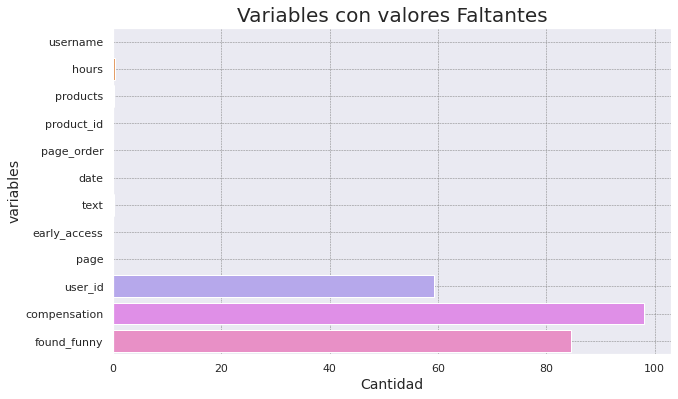

,Valores faltantes,Porcentaje
compensation,764719,98.1
found_funny,659143,84.6
user_id,461967,59.3
hours,2637,0.3
text,1839,0.2
products,1566,0.2
username,18,nan


In [13]:
#Valores faltantes
rev_missing = data_reviews.isna().sum()/len(data_reviews)*100
#se crea otra serie para usar como variable independiente.
columnas=data_reviews.columns
##Gráfico
plt.figure(figsize = (10,6))
sns.barplot( x = rev_missing, y=columnas)
plt.title("Variables con valores Faltantes",fontsize=20)
plt.xlabel("Cantidad",fontsize=14)
plt.ylabel("variables",fontsize=14)
ax = plt.axes()
plt.grid(True,color='grey', linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)
plt.show()

def missing_percentage(df):
    total = data_reviews.isnull().sum().sort_values(ascending = False)[data_reviews.isnull().sum().sort_values(ascending = False) != 0]
    percent = round(data_reviews.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(data_reviews.isnull().sum().sort_values(ascending = False)/len(data_reviews)*100,2) != 0]
    return pd.concat([total, percent], axis=1, keys=['Valores faltantes','Porcentaje'])
missing_percentage(data_reviews)

Descartamos las variables de las columnas poco significaticas por no aportar informacion relevante para este estudio, como lo son: products, page_order, date, page, early_acces, "found_funny" y "compensation".

Por otro lado "userd_id" contiene casi el 60% de valores faltantes y como esta variable se refiere al número unico de identificación del usuario, la eliminamos y usamos "username".

Los datos nulos de *username*, *text* y *hours* serán descartados debido a que tienen un porcentaje muy pequeño respecto a la totalidad de los datos.

In [14]:
#se reorganiza el dataset tomando solo las columnas relevantes
data_reviews_1 = data_reviews[['username','product_id','text','hours']].copy()
#se eliminan los valores faltantes
data_reviews_1.dropna(subset=['username'], how='all', inplace=True)
data_reviews_1.dropna(subset=['text'], how='all', inplace=True)
data_reviews_1.dropna(subset=['hours'], how='all', inplace=True)
#impresión de tipo de datos
data_reviews_1.dtypes

username       object
product_id      int64
text           object
hours         float64
dtype: object

In [15]:
data_reviews_1.isna().sum()

username      0
product_id    0
text          0
hours         0
dtype: int64

### **Games**

In [16]:
print(f'Nº de filas: {data_games.shape[0]}')
print(f'Nº de columnas: {data_games.shape[1]}')

Nº de filas: 32135
Nº de columnas: 16


In [17]:
data_games.head(3)

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",4.5,http://steamcommunity.com/app/761140/reviews/?...,['Single-player'],4.99,False,761140.0,Kotoshiro,NaN,nan
1,"Making Fun, Inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...",nan,http://steamcommunity.com/app/643980/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free To Play,False,643980.0,Secret Level SRL,Mostly Positive,nan
2,Poolians.com,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"['Free to Play', 'Simulation', 'Sports', 'Casu...",nan,http://steamcommunity.com/app/670290/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free to Play,False,670290.0,Poolians.com,Mostly Positive,nan


**Data Games**: contiene información sobre los juegos que ofrece la plataforma. A continuación describiremos sus principales características:


*   **publisher**: editor
*   **genres** géneros
*   **title / app_name**: nombre del juego
*   **release_date**: fecha en que se comenzo a comercializar
*   **tags**: etiquetas
*   **specs**: características del juego
*   **id**: identificación númerica y única del juego
*   **developer**: desarrollador
*   **sentiment**: asigna al juego un "valor característico" en función de la valoración que le pusieron los usuarios, si es más o menos valorado; también diferencia los casos en que no hay suficientes reseñas para evaluarlo.
*   **metascore**: valoración númerica de 1 a 100, que tiene ese juego en la web www.metacritic.com 

Miramos las principales estadísticas de las variables numéricas

In [18]:
data_games.describe()

,discount_price,id,metascore
count,225.0,32133.0,2607.0
mean,11.9,451757.4,72.3
std,17.5,182714.0,10.8
min,0.5,10.0,20.0
25%,1.4,329280.0,66.0
50%,4.2,452060.0,74.0
75%,22.7,593400.0,80.0
max,140.0,2028850.0,96.0


Y sus valores nulos:

In [19]:
data_games.isna().sum()

publisher          8062
genres             3283
app_name              2
title              2050
url                   0
release_date       2067
tags                163
discount_price    31910
reviews_url           2
specs               670
price              1377
early_access          0
id                    2
developer          3299
sentiment          7182
metascore         29528
dtype: int64

* *Casi todas las Variables tienen elementos faltantes. Detallamos las principales:

1.  discount_price **98%** (31.910) 
2.  metascore **98%** (29.528)  
3.  publisher 59% c/u (8.062)  
4.  sentiment 0,3% (7.182) 
5.  developer 0,2% (3.299)  
6.  genres 0,2% (3.283)
   

El atributo **"id"** tiene un numero unico que representa al juego **"title"** o **"app_name"** y se corresponde con el atributo **"product_id"** que esta en el data_reviews donde nos representa de que juego esta haciendo la reseña el usuario.

Renombramos **id**, a fin de que coincida con el dataset de Reviews donde se nombra **"product_id"**.

In [20]:
data_games.rename(columns={'id':'product_id'},inplace=True)

*¿Es mejor trabajar con app_name o con title?*

In [21]:
app_name=data_games['app_name'].value_counts()
app_name

Soundtrack                                                                                             3
Hero                                                                                                   2
Prism                                                                                                  2
Slice&Dice                                                                                             2
Archangel                                                                                              2
                                                                                                      ..
Devilian - Tempest Pack                                                                                1
DCS: Black Shark 2                                                                                     1
Superdimension Neptune VS Sega Hard Girls - Segami's Astral Brave| 瀬賀初美追加クラス『我が道を行く者』 | 瀨賀美的「自行其道者」    1
Call of Duty®: Ghosts - Weapon - The Ripper            

In [22]:
title=data_games['title'].value_counts()
title

Soundtrack                                3
Borealis                                  2
Colony                                    2
Goro                                      2
The Dream Machine: Chapter 4              2
                                         ..
Otto the Odd Ostrich                      1
Virtual Families                          1
Age of Wonders II: The Wizard's Throne    1
Get Rich or Die Gaming                    1
Yu-Gi-Oh! ARC-V Sora and Dipper           1
Name: title, Length: 30054, dtype: int64

In [23]:
data_games.isna().sum()

publisher          8062
genres             3283
app_name              2
title              2050
url                   0
release_date       2067
tags                163
discount_price    31910
reviews_url           2
specs               670
price              1377
early_access          0
product_id            2
developer          3299
sentiment          7182
metascore         29528
dtype: int64

Como se puede ver para estas dos variables existen valores faltantes que serán completados.

App name y title tienen la misma información, es mejor trabajar con app_name porque posee menos valores faltantes

In [24]:
data_games['app_name'] = data_games['app_name'].fillna(data_games['title'])
data_games['title'] = data_games['title'].fillna(data_games['app_name'])

In [25]:
data_games.isna().sum()

publisher          8062
genres             3283
app_name              2
title                 2
url                   0
release_date       2067
tags                163
discount_price    31910
reviews_url           2
specs               670
price              1377
early_access          0
product_id            2
developer          3299
sentiment          7182
metascore         29528
dtype: int64

Veamos la varible **"sentiment"**: por cada juego, simplifica en **"forma categorica"** el porcentaje de calificaciones positivas ("dedito arriba"), en relacion con las calificaciones negativas ("dedito abajo"), y el total de las reseñas o calificaciones sobre ese juego en particular. 

Tambien nos da informacion sobre si las reseñas sobre un juego en particular son muy escasas y por lo tanto no las caracteriza (ej: 1 users reviews, etc).

In [26]:
pd.unique(data_games['sentiment'])

array([nan, 'Mostly Positive', 'Mixed', '1 user reviews',
       '3 user reviews', '8 user reviews', 'Very Positive',
       'Overwhelmingly Positive', '6 user reviews', '5 user reviews',
       '2 user reviews', 'Very Negative', 'Positive', 'Mostly Negative',
       '9 user reviews', 'Negative', '4 user reviews', '7 user reviews',
       'Overwhelmingly Negative'], dtype=object)

In [27]:
print(data_games['sentiment'].value_counts())

Mixed                      4103
Very Positive              3868
Positive                   3281
Mostly Positive            2744
1 user reviews             2496
2 user reviews             1756
3 user reviews             1231
4 user reviews              964
5 user reviews              846
Mostly Negative             802
6 user reviews              756
7 user reviews              619
8 user reviews              537
9 user reviews              488
Overwhelmingly Positive     303
Negative                    123
Very Negative                29
Overwhelmingly Negative       7
Name: sentiment, dtype: int64


Text(0.5, 1.0, 'Cantidad de juegos por tipo de caracterizacion del Atributo sentiment')

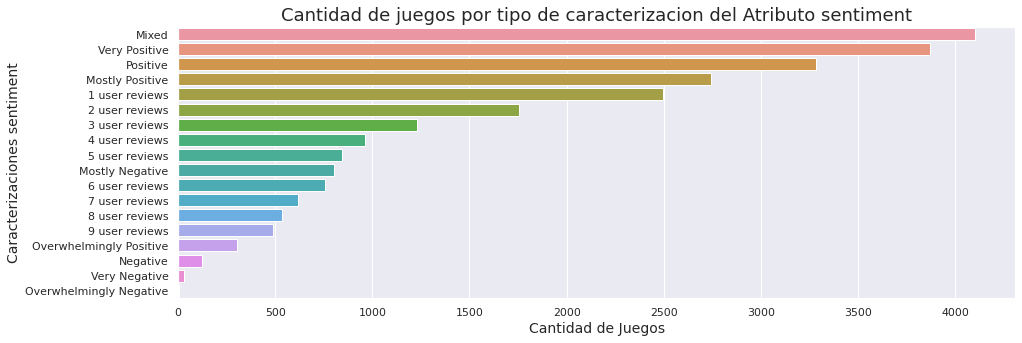

In [28]:
plt.subplots(figsize=(15, 5))

sns.countplot(data = data_games, y = 'sentiment', order = data_games['sentiment'].value_counts().index)
plt.title('Número de Calificaciones por Tipo')

plt.xlabel('Cantidad de Juegos',size=14)
plt.ylabel('Caracterizaciones sentiment',size=14)
plt.title("Cantidad de juegos por tipo de caracterizacion del Atributo sentiment" ,size=18)

*  **¿Existe alguna relación entre la valoración y la cantidad horas jugadas?**

In [29]:
data_reviews_1

,username,product_id,text,hours
0,Chaos Syren,725280,This would not be acceptable as an entertainme...,0.1
1,Ariman1,328100,Addictive RPG ! Works fine on linux though it ...,13.2
2,freakfantom,725280,Прикольная стрелялка. Взял дешево на распродаже.,0.1
3,The_Cpt_FROGGY,631920,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,7.8
4,the_maker988,35140,"This game was way to linear for me, and compar...",8.2
...,...,...,...,...
779302,Vidaar,252490,Summary: Rust is a survival game created by Fa...,783.5
779303,Nikolai Belinski,252490,Coolest Game Eva,55.1
779304,RancorZealot,252490,Should you buy RUST? Uh... YES. The BEST Survi...,203.5
779305,Jerry,252490,Great game!,139.8


In [30]:
data_reviews_2 = data_reviews_1.merge(data_games[['product_id','sentiment']],on='product_id')

In [31]:
data_reviews_2.head()

,username,product_id,text,hours,sentiment
0,Chaos Syren,725280,This would not be acceptable as an entertainme...,0.1,Positive
1,freakfantom,725280,Прикольная стрелялка. Взял дешево на распродаже.,0.1,Positive
2,Ariman1,328100,Addictive RPG ! Works fine on linux though it ...,13.2,Mixed
3,dll3z,328100,do not buy this game,0.4,Mixed
4,Nyazicat,328100,For some reason I entirely derped out and boug...,2.2,Mixed


                         product_id  hours
sentiment                                 
Very Positive              237229.5  126.8
Mixed                      299846.0  118.3
Overwhelmingly Positive    207495.6   98.3
Mostly Positive            292535.2   84.2
Mostly Negative            295667.5   27.5
Positive                   434483.9   12.8
Overwhelmingly Negative    264960.2    7.9
9 user reviews             478101.8    7.4
7 user reviews             440315.6    6.9
5 user reviews             479198.0    6.4
Very Negative              310183.6    6.0
4 user reviews             465734.2    5.8
1 user reviews             530103.9    5.6
6 user reviews             461011.4    5.3
8 user reviews             421662.6    5.1
2 user reviews             506500.7    3.7
3 user reviews             507954.1    3.6
Negative                   361374.2    3.1


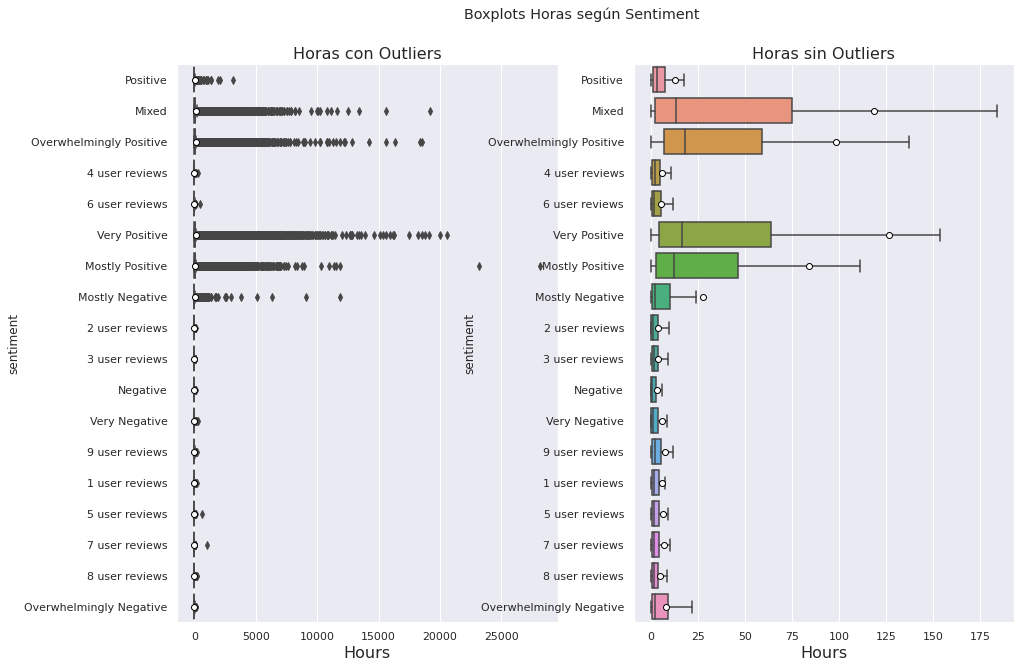

In [32]:
data_sentiment = data_reviews_2.groupby('sentiment').mean().sort_values(('hours'),ascending=False)
print(data_sentiment)

fig=plt.figure(figsize=(15,10))
plt.suptitle('Boxplots Horas según Sentiment', ha='center')
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
sns.boxplot(data = data_reviews_2, x = "hours",y='sentiment',showfliers=True,showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax1)

sns.boxplot(data = data_reviews_2, x = "hours",y='sentiment',showfliers=False,showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax2)
ax1.set_title("Horas con Outliers",fontsize=16)
ax2.set_title("Horas sin Outliers",fontsize=16)
ax1.set_xlabel('Hours',fontsize=16)
#ax1.set_ylabel('',fontsize=16)
ax2.set_xlabel('Hours',fontsize=16)
#ax2.set_ylabel('Hours',fontsize=16)
fig.subplots_adjust(top=0.9)
plt.show()

No existen diferencias significativas en cuanto a la cantidad de horas jugadas con valoraciones positivas y valoraciones negativas, por lo que la variable sentiment no será considerada. 



- Seleccionamos aquellos features que nos seran útiles a la hora de realizar las predicciones.

- Nos serán útiles las columnas de title, para poder identificar el nombre de los juegos, y del id de los juegos, para realizar el cruce de datos con Data Reviews, donde los juegos estan identificados con el id.

In [33]:
data_games_1 = data_games[['title','product_id']].copy()
data_games_1 

,title,product_id
0,Lost Summoner Kitty,761140.0
1,Ironbound,643980.0
2,Real Pool 3D - Poolians,670290.0
3,弹炸人2222,767400.0
4,Log Challenge,773570.0
...,...,...
32130,Colony On Mars,773640.0
32131,LOGistICAL: South Africa,733530.0
32132,Russian Roads,610660.0
32133,EXIT 2 - Directions,658870.0


**Valores nulos**

In [34]:
data_games_1.isnull().sum()

title         2
product_id    2
dtype: int64

* *Variables con elementos faltantes:*  

1. *title* **0.006%%** (2)
2. *product_id* **0.006%** (2)


Los datos nulos serán descartados debido a que tienen un porcentaje muy pequeño respecto a la totalidad de los datos.

In [35]:
data_games_1 = data_games_1.dropna()

In [36]:
data_games_1.isnull().sum()
data_games_1

,title,product_id
0,Lost Summoner Kitty,761140.0
1,Ironbound,643980.0
2,Real Pool 3D - Poolians,670290.0
3,弹炸人2222,767400.0
4,Log Challenge,773570.0
...,...,...
32130,Colony On Mars,773640.0
32131,LOGistICAL: South Africa,733530.0
32132,Russian Roads,610660.0
32133,EXIT 2 - Directions,658870.0


**Indexacion**

Indexamos **product_id** a fin de poder realizar un mejor cruce con el Dataset de Reviews

In [37]:
data_games_1.dtypes

title          object
product_id    float64
dtype: object

El tipo de dato debe ser entero para **product_id**, para poder realizar la indexación

In [38]:
data_games_1[('product_id')] = data_games_1['product_id'].astype(int)

In [39]:
data_games_modelo = data_games_1.set_index('product_id', drop=True)
data_games_modelo

,title
product_id,
761140,Lost Summoner Kitty
643980,Ironbound
670290,Real Pool 3D - Poolians
767400,弹炸人2222
773570,Log Challenge
...,...
773640,Colony On Mars
733530,LOGistICAL: South Africa
610660,Russian Roads


In [40]:
data_games_modelo.dtypes

title    object
dtype: object

El tipo de dato de pruduct_id y title resultan ser object, siendo acorde para llevar a cabo nuestras recomendaciones a posteriori.

### **Preguntas**

*  **¿Cuántos usuarios únicos hay?**

In [41]:
print(len(data_reviews_1['username'].unique()))

538238


*   **¿Cuántas calificaciones hay?**

In [42]:
print(data_reviews_1.shape[0])

774825


*  **¿Cuántos juegos hay?**

In [43]:
print(data_games_modelo.shape[0])

32132


*  **¿Cuántos juegos calificó cada usuario?**

In [44]:
reviews_por_usuario = data_reviews_1.username.value_counts()
print(reviews_por_usuario)

123              213
Alex             189
Chris            153
Nick             142
Matt             137
                ... 
nice2mice          1
Big FAt Idiot      1
trold              1
TheeCitra          1
NetGeek15          1
Name: username, Length: 538238, dtype: int64


Veamos cómo es la distribución de las calificaciones por usuario

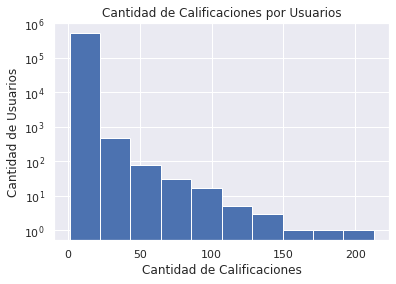

In [45]:
plt.hist(reviews_por_usuario, log=True)

plt.xlabel('Cantidad de Calificaciones')
plt.ylabel('Cantidad de Usuarios')
plt.title('Cantidad de Calificaciones por Usuarios')
plt.show()

Observando el gráfico la mayoría de los juegos no superan los 200 usuarios. 

*  **¿Cuántos juegos fueron calificados?**

In [46]:
print(len(data_reviews_1['product_id'].unique()))

12612


*  **¿cuáles son los juegos más populares?¿Y los menos populares?**

- Se eliminan aquellos valores que se encuentran duplicados en product_id, ya que sólo puede haber 1 juego con el mismo Id.

In [47]:
data_games_modelo = data_games_modelo[~data_games_modelo.index.duplicated(keep='first')]
data_games_modelo

,title
product_id,
761140,Lost Summoner Kitty
643980,Ironbound
670290,Real Pool 3D - Poolians
767400,弹炸人2222
773570,Log Challenge
...,...
773640,Colony On Mars
733530,LOGistICAL: South Africa
610660,Russian Roads


In [48]:
games_jugados = data_reviews_1.product_id.value_counts()
games_jugados.index = data_games_modelo.loc[games_jugados.index].title
games_jugados

title
Team Fortress 2                       18334
Rust                                  10204
Borderlands 2                          7299
Fallout 4                              7094
Grand Theft Auto V                     5962
                                      ...  
German Fortress 3D                        1
Singularity Roller                        1
The Adventures of Capitano Navarro        1
The Forgotten Forest                      1
Navalia                                   1
Name: product_id, Length: 12612, dtype: int64

El juego con mayor cantidad de reviewa es Team Fortress con 18334 calificaciones.

Algunos de los juegos con 1 sola reseña son:  
German Fortress 3D,                        
Singularity Roller,                       
The Adventures of Capitano Navarro,        
The Forgotten Forest,                      
Navalia.                     

*   **¿Cuántas horas jugó cada usuario al comentar?**

In [49]:
data_reviews_1.hours.describe()

count   774825.0
mean       111.9
std        390.2
min          0.0
25%          4.0
50%         15.3
75%         59.7
max      28164.0
Name: hours, dtype: float64

In [50]:
reviews_por_horas = data_reviews_1.hours.value_counts()
print(reviews_por_horas)

0.2       11269
0.3        9489
0.1        9191
0.4        8589
0.5        8274
          ...  
1595.0        1
2222.2        1
3805.1        1
3575.0        1
5484.6        1
Name: hours, Length: 21739, dtype: int64


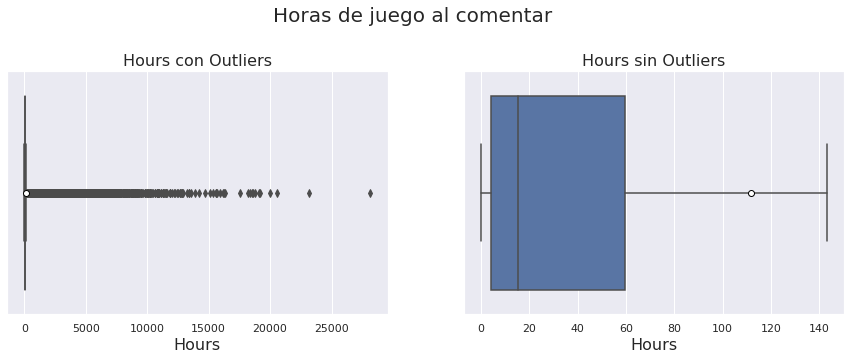

In [51]:
fig=plt.figure(figsize=(15,5))
plt.suptitle('Horas de juego al comentar',fontsize=20, ha='center')
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
sns.boxplot(data = data_reviews_1,x='hours',showfliers=True,showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax1)

sns.boxplot(data = data_reviews_1,x='hours',showfliers=False,showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax2)
ax1.set_title("Hours con Outliers",fontsize=16)
ax2.set_title("Hours sin Outliers",fontsize=16)
ax1.set_xlabel('Hours',fontsize=16)
#ax1.set_ylabel('Rooms',fontsize=16)
ax2.set_xlabel('Hours',fontsize=16)
#ax2.set_ylabel('Rooms',fontsize=16)
fig.subplots_adjust(top=0.8)
plt.show()

La mediana indica que los usuarios jugaron 15.3 horas a la hora de realizar los comentarios. Este valor puede resultar más representativo que el promedio dado que la distribución tiene una marcada cola hacia la derecha.

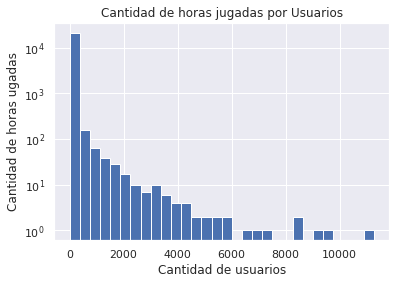

In [52]:
plt.hist(reviews_por_horas, log=True, bins = 30)

plt.xlabel('Cantidad de usuarios')
plt.ylabel('Cantidad de horas ugadas')
plt.title('Cantidad de horas jugadas por Usuarios')
plt.show()

Hay una gran cantidad de usuarios que jugaron menos de 1 hora, que se puede considerar un tiempo suficiente para categorizar al usuario como que jugo el juego.

### **Dataset para el modelo**

**Análisis d la información**
 
**En el Dataset Reviews**, solo tenemeos un atributo númerico "hours" el cual podemos utilizar como target, utilizandolo como indicador de satisfacción o preferencia del usuario con un juego. A mayor hs de juego, mayor seria la calificacion de ese usuario sobre ese juego.

Otro indicador que podría usarse es "text" con la crítica del usuario sobre el juego y transformarlo en un valor númerico de satisfacción utilizando NLP: Procesamiento de Lenguaje Natural. Pero por el momento, no utilizaremos esta técnica.
     
Por lo tanto, asumimos que el tiempo de juego **"hours"** es una parte muy importante de los intereses del usuario y la utilizaremos como clasificacion (rating).

*  **Seleccionamos las variables que nos serán útiles para realizar las predicciones**

In [53]:
data_reviews_2

,username,product_id,text,hours,sentiment
0,Chaos Syren,725280,This would not be acceptable as an entertainme...,0.1,Positive
1,freakfantom,725280,Прикольная стрелялка. Взял дешево на распродаже.,0.1,Positive
2,Ariman1,328100,Addictive RPG ! Works fine on linux though it ...,13.2,Mixed
3,dll3z,328100,do not buy this game,0.4,Mixed
4,Nyazicat,328100,For some reason I entirely derped out and boug...,2.2,Mixed
...,...,...,...,...,...
775464,rt974,518790,"Hi,\nI discovered this game yesterday on my pe...",9.4,Mostly Positive
775465,Fallenglory,518790,The Hunter was and is still the most realistic...,35.8,Mostly Positive
775466,GooseMan,518790,Very good!,32.4,Mostly Positive
775467,lazyboy82,518790,Update after 60+ hours:\nI decided to quit the...,96.9,Mostly Positive


In [54]:
data_reviews_3 = data_reviews_2.copy()
#data_reviews_3 = data_reviews_3.loc[:, ('username', 'product_id', 'hours')]
data_reviews_3

,username,product_id,text,hours,sentiment
0,Chaos Syren,725280,This would not be acceptable as an entertainme...,0.1,Positive
1,freakfantom,725280,Прикольная стрелялка. Взял дешево на распродаже.,0.1,Positive
2,Ariman1,328100,Addictive RPG ! Works fine on linux though it ...,13.2,Mixed
3,dll3z,328100,do not buy this game,0.4,Mixed
4,Nyazicat,328100,For some reason I entirely derped out and boug...,2.2,Mixed
...,...,...,...,...,...
775464,rt974,518790,"Hi,\nI discovered this game yesterday on my pe...",9.4,Mostly Positive
775465,Fallenglory,518790,The Hunter was and is still the most realistic...,35.8,Mostly Positive
775466,GooseMan,518790,Very good!,32.4,Mostly Positive
775467,lazyboy82,518790,Update after 60+ hours:\nI decided to quit the...,96.9,Mostly Positive


In [55]:
print(data_reviews_3.isnull().sum())
print(data_reviews_3.shape)

username        0
product_id      0
text            0
hours           0
sentiment     142
dtype: int64
(775469, 5)


#### **Deteccion de outliers**

Aplicamos el método de IQR para eliminar los outliers de la variable "hours".


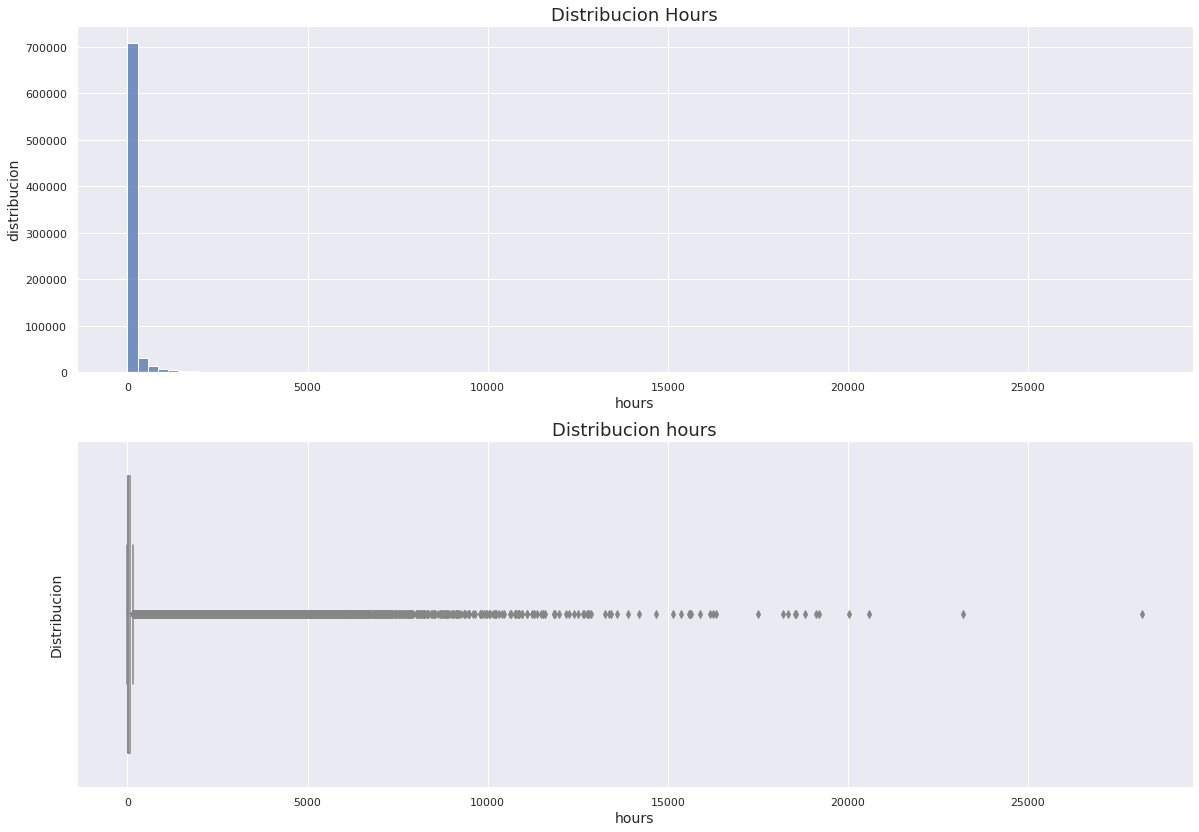

In [56]:
plt.subplots(figsize=(20, 14))

plt.subplot(2,1,1)
plt.title("Distribucion Hours" ,size=18)
sns.histplot(data_reviews_3, x= "hours", bins=100)
plt.xlabel('hours',size=14)
plt.ylabel('distribucion',size=14)

plt.subplot(2,1,2)
sns.boxplot(data = data_reviews_3, x= "hours",palette="Spectral",orient="h")
plt.xlabel('hours',size=14)
plt.ylabel('Distribucion',size=14)
plt.title("Distribucion hours" ,size=18)

plt.show()

In [57]:
Q1 = data_reviews_3.hours.quantile(0.25)
Q3 = data_reviews_3.hours.quantile(0.75)

IQR = Q3 - Q1
hours_min = Q1 #- (IQR*1.5)  Se toma solo el primer cuartil ya que da un número negativo
hours_max = Q3 + (IQR*1.5)

print("las horas maxima son {}, las horas minimas son {} y el IQR {}" .format(hours_max,hours_min,IQR))
print("")

las horas maxima son 143.0, las horas minimas son 4.0 y el IQR 55.6



In [58]:
data_reviews_3a = data_reviews_3[(data_reviews_3.hours > hours_min)&(data_reviews_3.hours< hours_max)]

In [59]:
a=len(data_reviews_3a)
b=len(data_reviews_3)
c=b-a
e=c*100/b
print("La cantidad de reviews que perdemos son: ",c,"reviews; un ",e, " % de las reseñas." )

La cantidad de reviews que perdemos son:  305897 reviews; un  39.44670902382945  % de las reseñas.


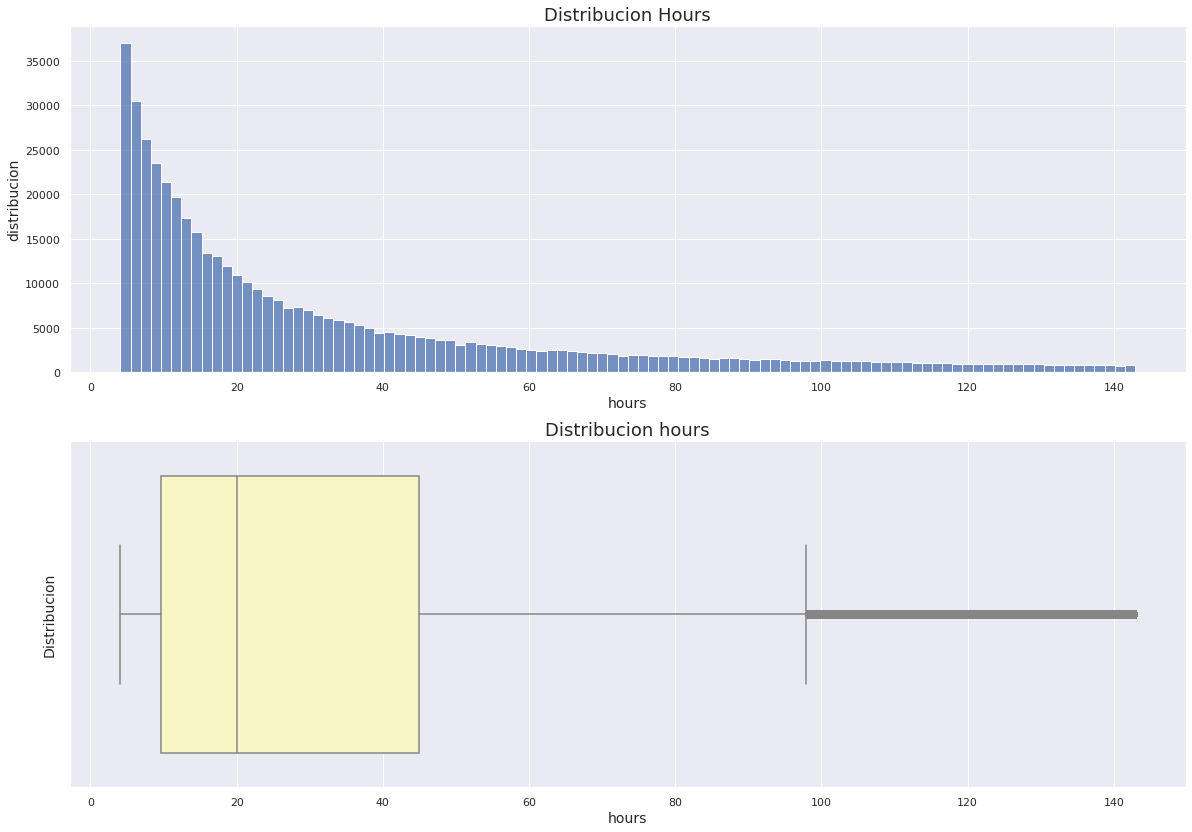

In [60]:
plt.subplots(figsize=(20, 14))

plt.subplot(2,1,1)
plt.title("Distribucion Hours" ,size=18)
sns.histplot(data_reviews_3a, x= "hours", bins=100)
plt.xlabel('hours',size=14)
plt.ylabel('distribucion',size=14)

plt.subplot(2,1,2)
sns.boxplot(data = data_reviews_3a, x= "hours",palette="Spectral",orient="h")
plt.xlabel('hours',size=14)
plt.ylabel('Distribucion',size=14)
plt.title("Distribucion hours" ,size=18)

plt.show()

Como la variable **"hours"** la queremos convertir un un "ranking" pero su distribución es muy asimetrica ya que cuentas con muy pocas reseñas con muchas horas jugadas y con una gran cantidad con pocas horas jugadas, vamos a eliminar los outliers de forma manual, tomando solo aquellos que están por encima del 3er cuartil.

Cabe destacar que el concepto de ranking implica de cierta forma, que las distancias que hay entre "punto y punto" son iguales. Por ejemplo el puntaje 1 cabe 5 veces en el puntaje 5.

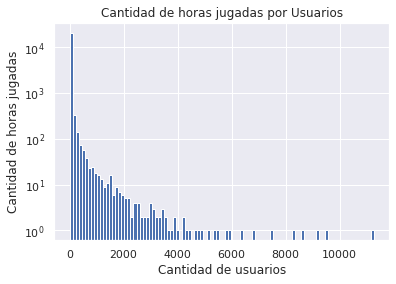

In [61]:
reviews_por_horas_1 = data_reviews_3.hours.value_counts()

plt.hist(reviews_por_horas_1, log=True, bins = 100)

plt.xlabel('Cantidad de usuarios')
plt.ylabel('Cantidad de horas jugadas')
plt.title('Cantidad de horas jugadas por Usuarios')
plt.show()



In [62]:
data_reviews_3b = data_reviews_3.loc[data_reviews_3.hours < 4000]

In [63]:
a=len(data_reviews_3b)
b=len(data_reviews_3)
c=b-a
e=c*100/b
print("La cantidad de reviews que perdemos son: ",c,"reviews; un ",e, " % de las reseñas." )

La cantidad de reviews que perdemos son:  1232 reviews; un  0.15887159899364126  % de las reseñas.


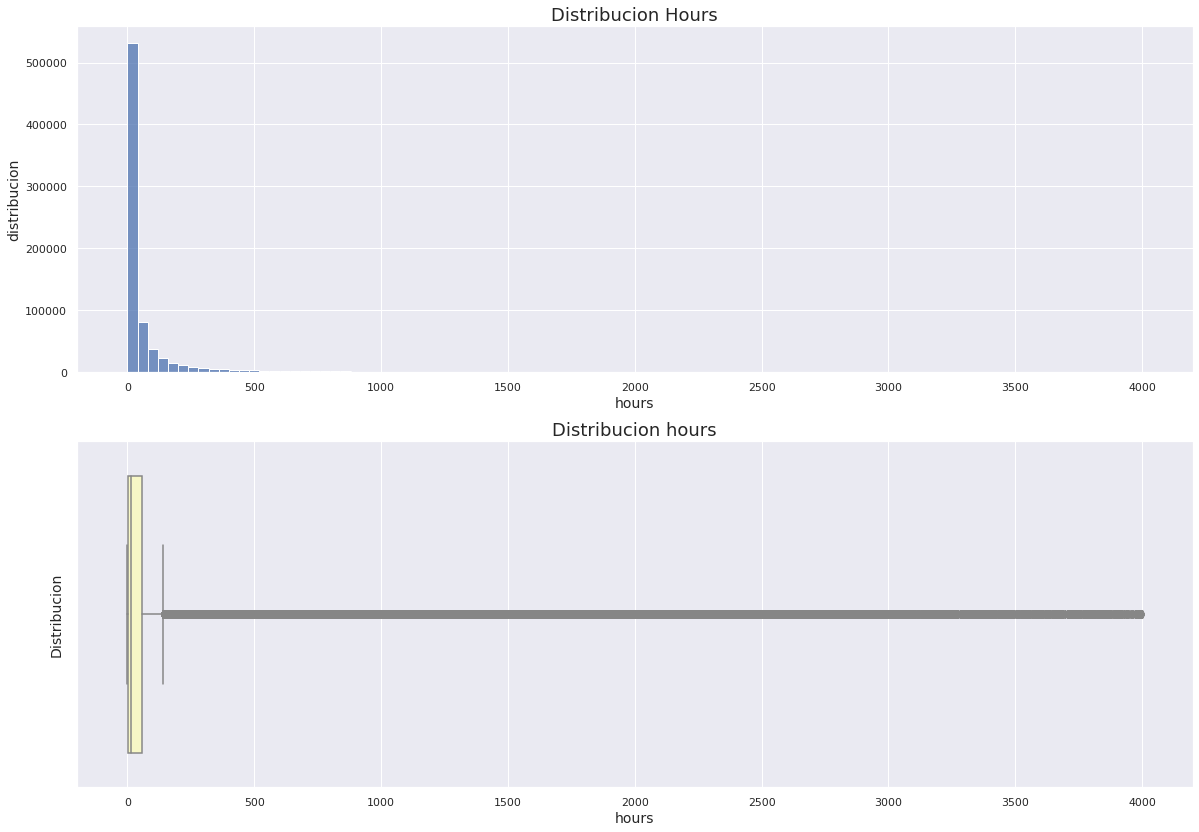

In [64]:
plt.subplots(figsize=(20, 14))

plt.subplot(2,1,1)
plt.title("Distribucion Hours" ,size=18)
sns.histplot(data_reviews_3b, x= "hours", bins=100)
plt.xlabel('hours',size=14)
plt.ylabel('distribucion',size=14)

plt.subplot(2,1,2)
sns.boxplot(data = data_reviews_3b, x= "hours",palette="Spectral",orient="h")
plt.xlabel('hours',size=14)
plt.ylabel('Distribucion',size=14)
plt.title("Distribucion hours" ,size=18)

plt.show()

#### **Encoder**

In [65]:
data_reviews_3b

,username,product_id,text,hours,sentiment
0,Chaos Syren,725280,This would not be acceptable as an entertainme...,0.1,Positive
1,freakfantom,725280,Прикольная стрелялка. Взял дешево на распродаже.,0.1,Positive
2,Ariman1,328100,Addictive RPG ! Works fine on linux though it ...,13.2,Mixed
3,dll3z,328100,do not buy this game,0.4,Mixed
4,Nyazicat,328100,For some reason I entirely derped out and boug...,2.2,Mixed
...,...,...,...,...,...
775464,rt974,518790,"Hi,\nI discovered this game yesterday on my pe...",9.4,Mostly Positive
775465,Fallenglory,518790,The Hunter was and is still the most realistic...,35.8,Mostly Positive
775466,GooseMan,518790,Very good!,32.4,Mostly Positive
775467,lazyboy82,518790,Update after 60+ hours:\nI decided to quit the...,96.9,Mostly Positive


**username** es el nombre de cada usuario y es único.
Realizamos encoding para esta variable.

In [66]:
Labelencoder = LabelEncoder()
data_reviews_3b["username"] = Labelencoder.fit_transform(data_reviews_3b["username"])

In [67]:
data_reviews_3b

,username,product_id,text,hours,sentiment
0,62190,725280,This would not be acceptable as an entertainme...,0.1,Positive
1,432248,725280,Прикольная стрелялка. Взял дешево на распродаже.,0.1,Positive
2,26722,328100,Addictive RPG ! Works fine on linux though it ...,13.2,Mixed
3,423209,328100,do not buy this game,0.4,Mixed
4,245739,328100,For some reason I entirely derped out and boug...,2.2,Mixed
...,...,...,...,...,...
775464,485923,518790,"Hi,\nI discovered this game yesterday on my pe...",9.4,Mostly Positive
775465,115291,518790,The Hunter was and is still the most realistic...,35.8,Mostly Positive
775466,136298,518790,Very good!,32.4,Mostly Positive
775467,456632,518790,Update after 60+ hours:\nI decided to quit the...,96.9,Mostly Positive


#### **Rating**

El valor de clasificacion (rating) que utilizaremos sera el de tiempo jugado (atributo "hours").

In [68]:
data_reviews_3b['rating'] = pd.qcut(data_reviews_3b.hours, 5, labels=['1', '2', '3', '4', '5'])

<Figure size 432x288 with 0 Axes>

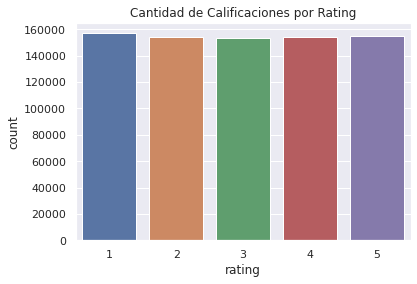

In [69]:
fig = plt.figure()
fig, ax = plt.subplots(figsize = (6,4))
plt.title('Cantidad de Calificaciones por Rating')
sns.countplot(data = data_reviews_3b, x ='rating')

In [70]:
pd.unique(data_reviews_3b['rating'])

['1', '3', '2', '4', '5']
Categories (5, object): ['1' < '2' < '3' < '4' < '5']

- Los valores resultan categóricos, ordenados de menor a mayor.
- Los pasamos a enteros, con el fin de poder seguir explorando sus datos.

In [71]:
data_reviews_3b['rating'] = data_reviews_3b['rating'].astype(int)

Reordenamos nuestro dataset, tomando solo las columnas necesarias para nuestro modelo

In [72]:
data_reviews_3b

,username,product_id,text,hours,sentiment,rating
0,62190,725280,This would not be acceptable as an entertainme...,0.1,Positive,1
1,432248,725280,Прикольная стрелялка. Взял дешево на распродаже.,0.1,Positive,1
2,26722,328100,Addictive RPG ! Works fine on linux though it ...,13.2,Mixed,3
3,423209,328100,do not buy this game,0.4,Mixed,1
4,245739,328100,For some reason I entirely derped out and boug...,2.2,Mixed,1
...,...,...,...,...,...,...
775464,485923,518790,"Hi,\nI discovered this game yesterday on my pe...",9.4,Mostly Positive,2
775465,115291,518790,The Hunter was and is still the most realistic...,35.8,Mostly Positive,4
775466,136298,518790,Very good!,32.4,Mostly Positive,4
775467,456632,518790,Update after 60+ hours:\nI decided to quit the...,96.9,Mostly Positive,5


In [73]:
data_reviews_modelo = data_reviews_3b[['username','product_id','rating']]
data_reviews_modelo

,username,product_id,rating
0,62190,725280,1
1,432248,725280,1
2,26722,328100,3
3,423209,328100,1
4,245739,328100,1
...,...,...,...
775464,485923,518790,2
775465,115291,518790,4
775466,136298,518790,4
775467,456632,518790,5


In [74]:
data_reviews_modelo.dtypes

username      int64
product_id    int64
rating        int64
dtype: object

Optimizamos las variables

In [75]:
#se optimizan los datatypes
data_reviews_modelo['username'] = data_reviews_modelo['username'].astype(np.int32)
data_reviews_modelo['product_id'] = data_reviews_modelo['product_id'].astype(np.int32)
data_reviews_modelo['rating'] = data_reviews_modelo['rating'].astype(np.int32)

In [76]:
data_reviews_modelo.dtypes

username      int32
product_id    int32
rating        int32
dtype: object

In [77]:
data_reviews_modelo

,username,product_id,rating
0,62190,725280,1
1,432248,725280,1
2,26722,328100,3
3,423209,328100,1
4,245739,328100,1
...,...,...,...
775464,485923,518790,2
775465,115291,518790,4
775466,136298,518790,4
775467,456632,518790,5


Tenemos int32 para todos los features, lo cual nos permitirá un mejor procesamiento de datos por menor utilizacion de memoria que si fueran Dtype int64.

- Creamos dos Dataset 

*  data_reviews_modelo, con username, product_id y rating. 
*  data_games_modelo, con product_id y title

Nos quedaran como base por si queremos hacer analisis diversos en otro notebook.

In [78]:
#data_reviews_modelo.to_csv('/content/gdrive/MyDrive/Colab Files/data_reviews_modelo.csv', index= False) # Guardamos el Dataset modificado en un nuevo archivo
#data_games_modelo.to_csv('/content/gdrive/MyDrive/Colab Files/data_games_modelo.csv', index= False) # Guardamos el Dataset modificado en un nuevo archivo

## **Filtro Colaborativo**



Para realizar el sistema de recomendacion con el metodo de filtro colaborativo vamos a usar la libreria Surprise


* Los métodos de filtrado colaborativo construyen un modelo basado en el comportamiento pasado de los usuarios (artículos comprados anteriormente, películas vistas y calificadas, horas de juegos jugados etc.). Este modelo se utiliza luego para predecir elementos en los que el usuario puede estar interesado.
- Ventajas: no necesitamos tener información acerca de los productos.
- Desventajas: necesitamos construir la matríz de utilidad (que es muy dispersa) y llenarla es costosa en tiempo y dinero.
* Para implementarlo, necesitamos un dataset donde cada fila represente un usuario, un juego y la calificación del usuario a ese juego.

### **Modelo Benchmarck**

Crearemos un benchmark que recomiende a los usuarios los juegos basados en su popularidad.

Es una recomendación muy sencilla que solo tomará aquellos juegos mas jugados, sin considerar características de ítem, usuarios, ni la interacción entre ellos.

In [79]:
#data_reviews_modelo.describe()
#data_games_modelo

data_reviews_modelo.head()

,username,product_id,rating
0,62190,725280,1
1,432248,725280,1
2,26722,328100,3
3,423209,328100,1
4,245739,328100,1


In [80]:
def get_popularity_recommendations(username, top=10):
    recomendations = games_jugados[~games_jugados.index.isin(
        data_reviews_modelo.query('username==@username').product_id)]
    #plot_table(recomendations.head(top))
    print(recomendations.head(top))

In [81]:
get_popularity_recommendations('774237')

title
Team Fortress 2       18334
Rust                  10204
Borderlands 2          7299
Fallout 4              7094
Grand Theft Auto V     5962
Undertale              5697
Warframe               5510
Portal 2               5498
DayZ                   5494
Robocraft              5292
Name: product_id, dtype: int64


In [82]:
#games_jugados.head(11)

### **Filtro Colaborativo a partir de descomposición UV**

In [83]:
!pip install surprise

In [84]:
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split

from surprise import SVD

#### **1. Dataset y Train/test split**

In [85]:
data_reviews_modelo.head()

,username,product_id,rating
0,62190,725280,1
1,432248,725280,1
2,26722,328100,3
3,423209,328100,1
4,245739,328100,1


In [86]:
data_games_modelo.head()

,title
product_id,
761140,Lost Summoner Kitty
643980,Ironbound
670290,Real Pool 3D - Poolians
767400,弹炸人2222
773570,Log Challenge


In [87]:
print(data_reviews_modelo.shape)
print(data_games_modelo.shape)

(774237, 3)
(32131, 1)


Llevamos el dataset al formato que le gusta a la biblioteca

In [88]:
  reader = Reader()

Luego, creamos el Dataset de Surprise usando Dataset.load_from_df

In [89]:
N_filas = 100000 # Limitamos el dataset a N_filas

data = Dataset.load_from_df(data_reviews_modelo[['username', 'product_id', 'rating']][:N_filas], reader)

In [90]:
trainset, testset = train_test_split(data, test_size=.25)

####  **2. Entrenamiento**

Vamos a entrenar un algoritmo SVD.

In [91]:
algo = SVD()

Entrenamos sobre el trainset

In [92]:
algo.fit(trainset)

Y predecimos sobre el testset.

In [93]:
predictions = algo.test(testset)

Explorar las característica de predictions y alguno de sus elementos

In [94]:
predictions[1]

Prediction(uid=516467, iid=38410, r_ui=3.0, est=3.1191277544553895, details={'was_impossible': False})

En cambio, si queremos predecir para un usuario y una película en particular, usamos la función predict

In [95]:
algo.predict(219368		, 725280)  #62203

Prediction(uid=219368, iid=725280, r_ui=None, est=2.882611519648399, details={'was_impossible': False})

Exploremos un usuario, veamos cuáles juegos le gustaron  cuáles les recomienda el sistema.

Juegos que le gustaron

In [96]:
usuario = 219368
rating = 1   # le pedimos juegos a las que haya puesto al menos 1 en raking, porque se supone que ya lo jugó
data_user = data_reviews_modelo[(data_reviews_modelo['username'] == usuario) & (data_reviews_modelo['rating'] >= rating)]
data_user = data_user.reset_index(drop=True)
data_user['title'] = data_games_modelo['title'].loc[data_user.product_id].values
data_user

,username,product_id,rating,title
0,219368,631920,4,Somewhere on Zibylon
1,219368,261640,5,Borderlands: The Pre-Sequel
2,219368,104900,2,ORION: Prelude
3,219368,362810,2,Fighties
4,219368,207610,3,The Walking Dead
5,219368,245170,3,Skullgirls
6,219368,521330,2,Tuebor: I Will Defend
7,219368,250460,1,Bridge Constructor
8,219368,55110,2,Red Faction®: Armageddon™
9,219368,8190,1,Just Cause 2


Creamos donde vamos a guardar las recomendaciones

In [97]:
recomendaciones_usuario = data_games_modelo.iloc[:32132].copy()
print(recomendaciones_usuario.shape)
recomendaciones_usuario.head()

(32131, 1)


,title
product_id,
761140,Lost Summoner Kitty
643980,Ironbound
670290,Real Pool 3D - Poolians
767400,弹炸人2222
773570,Log Challenge


Sacamos del dataframe todos los juegos que ya sabemos que jugó

In [98]:
usuario_jugados = data_reviews_modelo[data_reviews_modelo['username'] == usuario]
print(usuario_jugados.shape)
usuario_jugados.head(12)

(12, 3)


,username,product_id,rating
11,219368,631920,4
104065,219368,261640,5
112597,219368,104900,2
165269,219368,362810,2
212215,219368,207610,3
248342,219368,245170,3
253951,219368,521330,2
292172,219368,250460,1
427806,219368,55110,2
440180,219368,8190,1


In [99]:
recomendaciones_usuario.drop(usuario_jugados.product_id, inplace = True)
recomendaciones_usuario = recomendaciones_usuario.reset_index()
recomendaciones_usuario.head()

,product_id,title
0,761140,Lost Summoner Kitty
1,643980,Ironbound
2,670290,Real Pool 3D - Poolians
3,767400,弹炸人2222
4,773570,Log Challenge


Y hacemos las recomendaciones

In [100]:
recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['product_id'].apply(lambda x: algo.predict(usuario, x).est)

In [101]:
recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=False)
print(recomendaciones_usuario.head(10))

       product_id                                       title  Estimate_Score
26947      271590                          Grand Theft Auto V             4.9
387         48700                  Mount &amp; Blade: Warband             4.9
841          9900                            Star Trek Online             4.6
23226      281990                                   Stellaris             4.5
4939       342200                         MechWarrior Online™             4.5
28190      314980                      Supreme Ruler Ultimate             4.2
20599      415200                          Motorsport Manager             4.2
29194      251060                         Wargame: Red Dragon             4.2
29062      228180  Action! - Gameplay Recording and Streaming             4.2
24121      224500                                    Gnomoria             4.1


Como se puede observar la lista de recomendación no coincide con el benchmark anteriormente como era de esperarse, ya que nuestro benchmark solo iba a recomendar los juegos mas populares a todos los usuarios, sin tomar ningún otro factor en cuenta.

####  **3. Evaluación**

Para el conjunto de testset, evaluamos el error RMSE entre las predicciones y las verdaderas calificaciones que le habían dado a los juegos. 

In [102]:
from surprise import accuracy

accuracy.rmse(predictions)

RMSE: 1.1253


1.1253370383205987

####  **4. Optimización**

Ejercicio: hacer un gráfico del desempeño del modelo en función del número de factores del SVD

In [103]:
from surprise.model_selection import cross_validate

rmse_test_means = []
factores = [1,2,4,8,16,32,64,128,256]

for factor in factores:
    print(f'\nNúmero de Factores: {factor}')
    algo = SVD(n_factors=factor)
    cv = cross_validate(algo, data, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))


Número de Factores: 1
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.1243  1.1265  1.1233  1.1247  0.0013  
Fit time          1.32    1.25    1.27    1.28    0.03    
Test time         0.38    0.34    0.25    0.32    0.05    

Número de Factores: 2
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.1316  1.1231  1.1221  1.1256  0.0043  
Fit time          1.35    1.31    1.32    1.33    0.02    
Test time         0.41    0.22    0.38    0.33    0.08    

Número de Factores: 4
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.1235  1.1314  1.1201  1.1250  0.0048  
Fit time          1.38    1.30    1.32    1.33    0.04    
Test time         0.22    0.21    0.21    0.21    0.01    

Número de Factores: 8
Evaluating RMSE of algorithm SVD on 3 split(s).

    

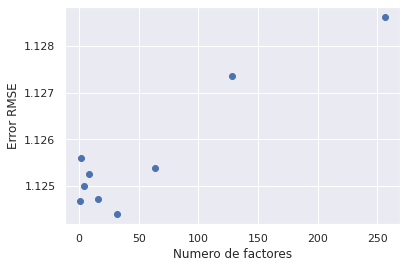

In [104]:
plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.show()

**Parámetros a optimizar:**

n_factors : el número de factores.

n_epochs : el número de iteraciones del descenso por gradiente estocástico.

lr_all : la tasa de aprendizaje de todos los parámetros.

reg_all : término de regularización para todos los parámetros.

In [105]:
#from surprise.model_selection import GridSearchCV

#param_grid = {'n_factors': [5,50,100],'n_epochs': [5, 10,20], 'lr_all': [0.001, 0.002, 0.005],
#              'reg_all': [0.002, 0.02, 0.2]}
#gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs = -1)
#gs.fit(data)

In [106]:
#print(gs.best_score['rmse'])
#print(gs.best_params['rmse'])

1.1245104642094061


{'n_factors': 5, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02}

In [107]:
algo_2 = SVD(n_factors=5, n_epochs=20, lr_all=0.005, reg_all= 0.02)
algo_2.fit(trainset)
predictions_2 = algo_2.test(testset)
accuracy.rmse(predictions_2)

RMSE: 1.1242


1.124169539843268

Comparando las métricas, se observa que se obtiene una variación muy mínima al optimizar los datos.

*  RMSE:            1.1151
*  RMSE Optimizado: 1.1126

**Conclusion**

Se puede considerar un RMSE de 1.1126 un buen resultado para un sistema de recomendacion, sin embargo puede que en la práctica no tenga muy buen resultado recomendando. Se debe emprolijar la variables horas para poder tener una mayor confianza, por ejemplo,  tener en cuenta la fecha que compro el juego cada persona con respecto a las horas jugadas, ya que no es lo mismo: un jugador que compró el juego hace un mes que hace un año.

## **Para pensar e investigar**

- Objetivo y Metodología 



> Trabajar con la variable **text**, la cual contiene la review de cada usuario, haciendo uso de Procesamiento de Lenguaje Natural **(NLP)** 


> Utilizando la librería **NLTK** de Python, con el objetivo de pasar los datos de texto a una matriz de sentimiento: clasificando los comentario en dos tipos positivos o negativos. Observando las palabras más frecuentes y cuales pueden relacionarse con la satisfacción del juego.


- Resultados esperados


> Validar la relación entre las horas jugadas y el texto de review, si efectivamente mientras más horas jugadas se tenga es más probable obtener un comentario positivo.


> Mejorar el sistema de recomendación y su adaptabildad al trabajar con el review de cada usuario.






### **Análisis exploratorio utilizando NLP**

En este punto se explorará el tipo de comentario de la columna "text" y se fundamentará en el Sistema de Recomendación realizado en el Poyecto 03, donde recomendaba aquellos juegos que fueron comentados por usuarios que realizaron su review, basandose en un rating de la cantidad de horas jugadas, mientra mayor es la cantidad de horas jugadas mayor es el número de rating asigando (1 al 5).

Sin embargo, al realizar esta diferenciación, se corre el riesgo de cometer dos tipos de errores: incorporar juegos con comentarios positivos con pocas horas de juego y juegos con comentarios negativos con muchas horas de juego. Para realizar la exploración se tratará de tomar los comentarios negativos a partir de las categorías provistas por el dataset games y extrapolarlas al dataset reviews a fin de saber cuáles son las palabras más frecuentes en cada uno de ellos.

Text(0.5, 1.0, 'Cantidad de juegos por tipo de caracterizacion del Atributo sentiment')

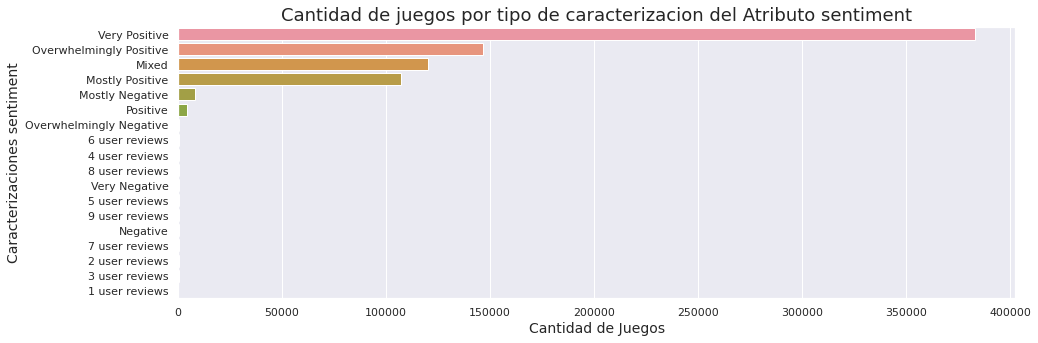

In [108]:
data_nlp = data_reviews_3b
plt.subplots(figsize=(15, 5))

sns.countplot(data = data_nlp, y = 'sentiment', order = data_nlp['sentiment'].value_counts().index)
plt.title('Número de Calificaciones por Tipo')

plt.xlabel('Cantidad de Juegos',size=14)
plt.ylabel('Caracterizaciones sentiment',size=14)
plt.title("Cantidad de juegos por tipo de caracterizacion del Atributo sentiment" ,size=18)

                         username  product_id  hours  rating
sentiment                                                   
Very Positive            261053.7    237459.1  115.9     3.0
Mixed                    262571.3    299885.4  110.1     2.9
Overwhelmingly Positive  261796.2    207715.6   90.6     3.2
Mostly Positive          263386.9    292625.5   77.3     2.8
Mostly Negative          266762.2    295677.8   23.6     1.9
Positive                 277081.9    434483.9   12.8     1.8
Overwhelmingly Negative  266301.8    264960.2    7.9     1.8
9 user reviews           270503.6    478101.8    7.4     1.6
7 user reviews           268239.5    440315.6    6.9     1.5
5 user reviews           269249.3    479198.0    6.4     1.5
Very Negative            281122.3    310183.6    6.0     1.5
4 user reviews           258131.9    465734.2    5.8     1.6
1 user reviews           274820.7    530103.9    5.6     1.5
6 user reviews           277143.7    461011.4    5.3     1.5
8 user reviews          

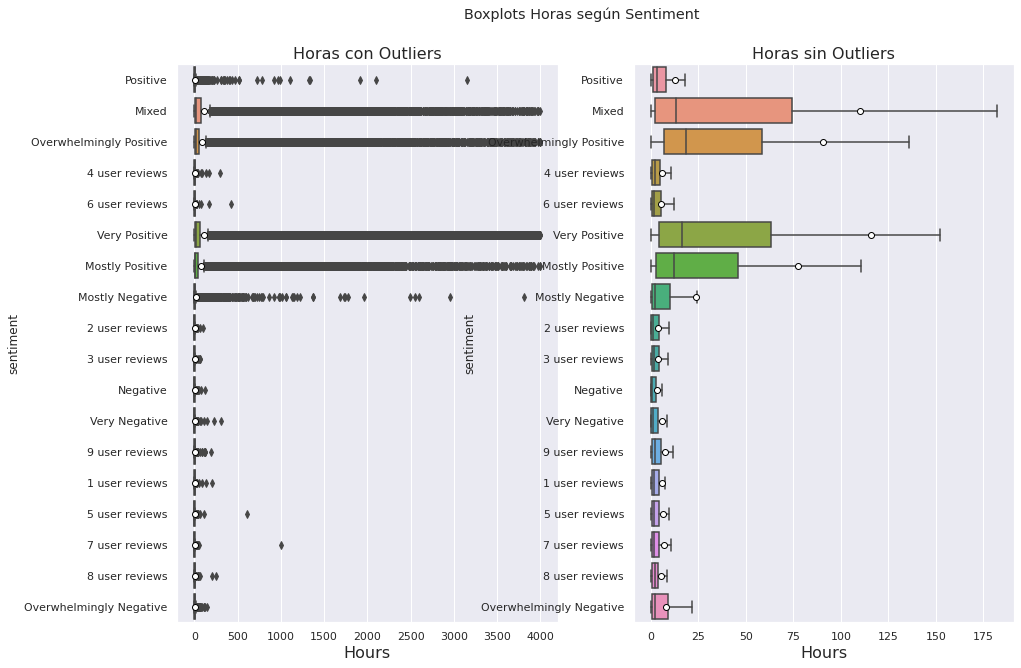

In [109]:
data_sentiment = data_nlp.groupby('sentiment').mean().sort_values(('hours'),ascending=False)
print(data_sentiment)

fig=plt.figure(figsize=(15,10))
plt.suptitle('Boxplots Horas según Sentiment', ha='center')
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
sns.boxplot(data = data_nlp, x = "hours",y='sentiment',showfliers=True,showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax1)

sns.boxplot(data = data_nlp, x = "hours",y='sentiment',showfliers=False,showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax2)
ax1.set_title("Horas con Outliers",fontsize=16)
ax2.set_title("Horas sin Outliers",fontsize=16)
ax1.set_xlabel('Hours',fontsize=16)
#ax1.set_ylabel('',fontsize=16)
ax2.set_xlabel('Hours',fontsize=16)
#ax2.set_ylabel('Hours',fontsize=16)
fig.subplots_adjust(top=0.9)
plt.show()

En el primer gráfico podemos ver que existe muy pocos juegos con "sentiment" negativo. Por lo que podemos concluir que el dataset está muy desbalanceado.

Por otro lado, en el segundo gráfico, observamos que no existen diferencias significativas como vimos anteriormente en cuanto a la cantidad de horas jugadas con valoraciones positivas y valoraciones negativas.

Por lo que, descartamos el uso de la variable "text" para la mejora del sistema de recomendación. De todas formas, se realizará el análisis exploratorio de la variable.

**Análisis exploratorio con NPL**

In [110]:
data_nlp=data_nlp[(data_nlp.sentiment=='Positive')|
                        (data_nlp.sentiment=='Mostly Negative')|
                        (data_nlp.sentiment=='Overwhelmingly Negative')|
                        (data_nlp.sentiment=='Very Negative')|
                        (data_nlp.sentiment=='Negative')]

In [111]:
data_nlp.head()

,username,product_id,text,hours,sentiment,rating
0,62190,725280,This would not be acceptable as an entertainme...,0.1,Positive,1
1,432248,725280,Прикольная стрелялка. Взял дешево на распродаже.,0.1,Positive,1
9,346039,631920,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,7.8,Positive,2
10,200357,631920,"Hmm...., what can I say? The game is good.\nIt...",7.0,Positive,2
11,219368,631920,What a cute little game! The puzzles are actua...,31.4,Positive,4


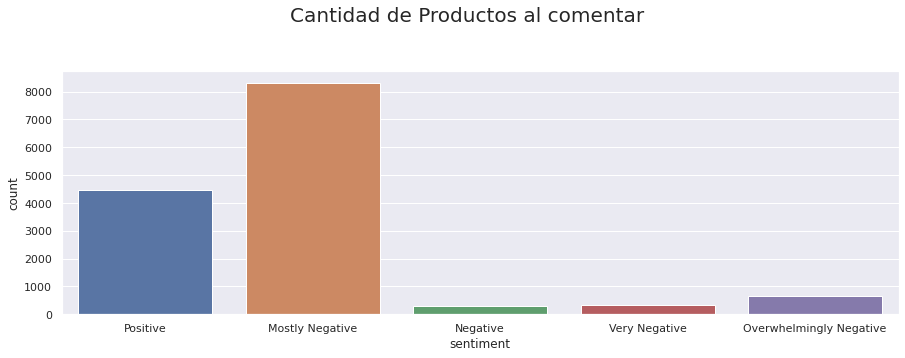

29 Litteratly garbage. Mostly Negative


In [112]:
fig=plt.figure(figsize=(15,5))
plt.suptitle('Cantidad de Productos al comentar',fontsize=20, ha='center')
sns.countplot(data_nlp.sentiment)
fig.subplots_adjust(top=0.8)
plt.show()


#breve exploración a través de un ejemplo aleatorio
index_random = np.random.randint(0,high = data_nlp.shape[0])
texto = data_nlp.iloc[index_random].text
print(index_random, texto, data_nlp.iloc[index_random].sentiment)

En el Gráfico se muestran las categorías de comentarios que serán incorporadas al análisis. 

**Tokenización, StopWords y Rarewords**

In [113]:
#data_nlp
filtrar = [] 
if True:
    filtrar.append("game")
    filtrar.append("I")
    filtrar.append("The")
    filtrar.append("It")
    filtrar.append("This")
    filtrar.append("one")
    filtrar.append("not")
    filtrar.append("get")
    filtrar.append("really")
    filtrar.append("games")
    filtrar.append("like")
    filtrar.append("play")
    filtrar.append("time")
    filtrar.append("would")
    filtrar.append("even")
    filtrar.append("good")
    filtrar.append("much")
    filtrar.append("You")
    filtrar.append("first")
    filtrar.append("make")
    filtrar.append("playing")
    filtrar.append("If")
    filtrar.append("played")
    filtrar.append("A")
    filtrar.append("There")

#TOKENIZACIÓN CON NLTK
titular_st = nltk.tokenize.sent_tokenize(texto)
titular_wt = nltk.tokenize.word_tokenize(texto)
    
#NORMALIZACIÓN 
stopwords = nltk.corpus.stopwords.words('english')
stopwords = [palabra for palabra in stopwords if 'not' not in palabra]

titular_wt_sin_sw = [word for word in titular_wt if word not in stopwords]

#FRECUENCIA DE PALABRAS
freq =  nltk.FreqDist(titular_wt_sin_sw)

### Aplicamos a todo el dataset


In [114]:
# data_nlp Completo

data_nlp_text = []
for i in range(data_nlp.shape[0]):
    texto = data_nlp.iloc[i].text
    texto = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(texto)
    texto = [word for word in texto if word not in stopwords]
    texto = [word for word in texto if word not in filtrar]

    data_nlp_text.append(texto)

In [115]:
data_nlp_text[0]

['acceptable',
 'entertainment',
 'back',
 'day',
 'graphics',
 'No',
 'effort',
 'made',
 'bring',
 'player',
 'story',
 'entertain']

In [116]:
import itertools   
#list(itertools.chain('ABC', 'DEF'))

In [117]:
#Unimos todos en una misma lista
data_nlp_text = list(itertools.chain(*data_nlp_text))
data_nlp_text[0:10]

['acceptable',
 'entertainment',
 'back',
 'day',
 'graphics',
 'No',
 'effort',
 'made',
 'bring',
 'player']

In [118]:
#Frecuencia de las palabras
freq_data_nlp_text = nltk.FreqDist(data_nlp_text)
freq_data_nlp_text

FreqDist({'acceptable': 39,
          'entertainment': 40,
          'back': 1107,
          'day': 395,
          'graphics': 1184,
          'No': 788,
          'effort': 157,
          'made': 1152,
          'bring': 124,
          'player': 743,
          'story': 1763,
          'entertain': 13,
          'Прикольная': 1,
          'стрелялка': 1,
          'Взял': 1,
          'дешево': 1,
          'на': 29,
          'распродаже': 1,
          'Somewhere': 5,
          'Zibylon': 9,
          'command': 52,
          'centre': 21,
          'read': 338,
          'repeat': 72,
          'Oh': 198,
          'boy': 56,
          'lost': 175,
          'contact': 26,
          'resourceful': 1,
          'planets': 175,
          'colonized': 1,
          'space': 708,
          'We': 146,
          'need': 951,
          'something': 1085,
          'somewhere': 90,
          'option': 262,
          'think': 1331,
          'send': 66,
          'drones': 23,
          'check

In [119]:
#Convertir en dataframe
df_freq_data_nlp_text = pd.DataFrame(list(freq_data_nlp_text.items()), columns = ["Word","Frequency"])
df_freq_data_nlp_text.head()

,Word,Frequency
0,acceptable,39
1,entertainment,40
2,back,1107
3,day,395
4,graphics,1184


In [120]:
#organizar por frecuencia
df_freq_data_nlp_text.sort_values('Frequency',ascending=False, inplace = True) #implace true hace el reemplazo, sino solo muestra pero no reemplaza
df_freq_data_nlp_text.head()

,Word,Frequency
272,fun,2689
223,10,2207
244,still,1960
10,story,1763
143,way,1742


In [121]:
#Reset index
df_freq_data_nlp_text.reset_index(drop = True, inplace=True)
df_freq_data_nlp_text.head()

,Word,Frequency
0,fun,2689
1,10,2207
2,still,1960
3,story,1763
4,way,1742


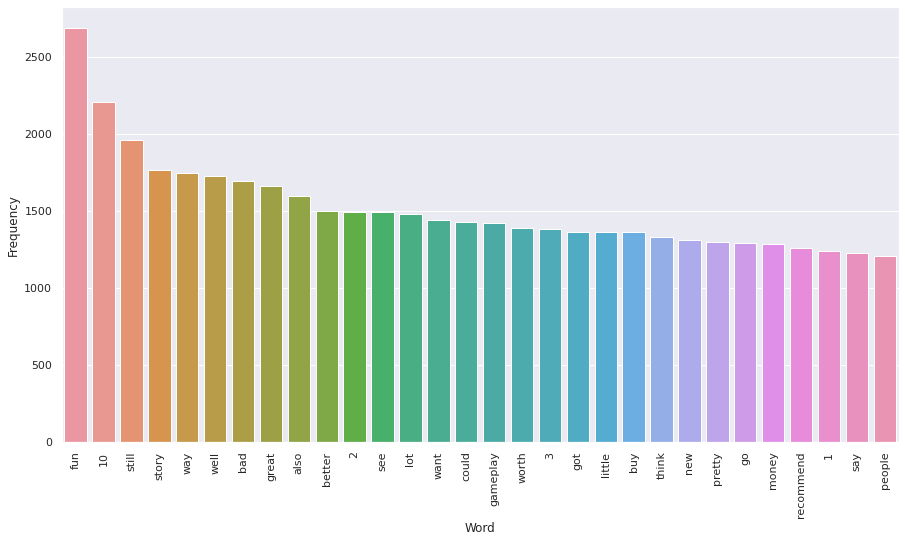

In [122]:
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_freq_data_nlp_text.iloc[:30].Word, y = df_freq_data_nlp_text.iloc[:30].Frequency)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

Las tres palabras más frecuentes en los textos fueron fun, 10 y still.

**Lematización**

In [123]:
# Importamos esta libreria que nos permite reemplazar caracteres
import re

# Importamos el lemmatizar de NLTK, y creamos el objeto // Importamos la función que nos permite Stemmizar de nltk y definimos el stemmer
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# Traemos nuevamente las stopwords
stopwords = nltk.corpus.stopwords.words('english')


In [124]:
#from nltk.corpus import wordnet

#def get_wordnet_pos(word):
 #   """Map POS tag to first character lemmatize() accepts"""
  #  tag = nltk.pos_tag([word])[0][1][0].upper()
   # tag_dict = {"J": wordnet.ADJ,
    #            "N": wordnet.NOUN,
     #           "V": wordnet.VERB,
      #          "R": wordnet.ADV}

  #  return tag_dict.get(tag, wordnet.NOUN)


In [125]:
import nltk.stem as stemmer
from nltk.stem.porter import *
stemmer = PorterStemmer()

In [126]:
# Recorremos todos los titulos y le vamos aplicando la Normalizacion y luega el Stemming a cada uno

titular_list=[]
for titular in  data_nlp.text:
    # Vamos a reemplzar los caracteres que no sean letras por espacios
    titular=re.sub("[^a-zA-Z]"," ",str(titular))
    # Pasamos todo a minúsculas
    titular=titular.lower()
    # Tokenizamos para separar las palabras
    titular=nltk.word_tokenize(titular)
    # Eliminamos las palabras demenos de 3 letras
    titular = [palabra for palabra in titular if len(palabra)>3]
    # Sacamos las Stopwords
    titular = [palabra for palabra in titular if not palabra in stopwords]
    
    ## Hasta acá Normalizamos, ahora a stemmizar

    # Aplicamos la funcion para buscar la raiz de las palabras
    titular = [stemmer.stem(palabra) for palabra in titular]
    # Por ultimo volvemos a unir el titular
    titular =" ".join(titular)
    
    # Vamos armando una lista con todos los reviewes
    titular_list.append(titular)

In [127]:
data_nlp["review_stem"] = titular_list
data_nlp.tail()

,username,product_id,text,hours,sentiment,rating,review_stem
768349,184215,50820,"Very nice artistic, drawn style. The marker is...",1.6,Positive,1,nice artist drawn style marker block sight gam...
768594,536484,358410,Constantly getting stuck looking at the ground...,0.1,Positive,1,constantli get stuck look ground despit enemi ...
768595,363535,358410,An often overlooked and under-rated DOS game.\...,2.1,Positive,1,often overlook rate game remak tri still match...
775059,259201,673760,Old school arcade in which you play as a space...,2.0,Positive,1,school arcad play spaceship pilot collect bonu...
775060,394755,673760,Hardcore space shooter with upgradable ship an...,1.2,Positive,1,hardcor space shooter upgrad ship hundr enemi ...


### **Dataset con review_steam y rating**

Armamos un nuevo dataset llamado dataset_stem que contenga solo las columnas review_steam y rating

In [128]:
data_nlp_stem= pd.concat([data_nlp.review_stem, data_nlp.rating],axis=1)
#data_nlp_stem.dropna(axis=0,inplace=True)  # Por si quedaron titulares vacios
data_nlp_stem.head()

,review_stem,rating
0,would accept entertain even back graphic effor...,1
1,,1
9,somewher zibylon zibylon command centr read re...,2
10,game good make think need think push button se...,2
11,cute littl game puzzl actual quit though make ...,4


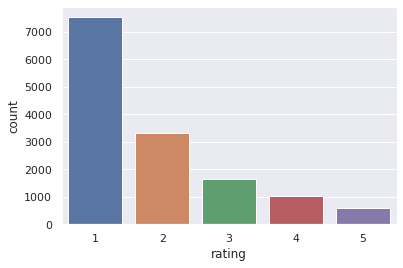

In [129]:
sns.countplot(data_nlp_stem.rating)
plt.show()

**Vectorizamos**


In [130]:
# Tomamos la lista de palabras y el vector que nos dice que valor de rating tiene el review

list_reviews = list(data_nlp_stem['review_stem'].values)
rating = data_nlp_stem['rating'].values

from sklearn.feature_extraction.text import CountVectorizer

# Usaremos solo las 1000 palabras con mas frecuencia en todo el corpus para generar los vectores
max_features=1000

# Es decir que cada instancia tendrá 1000 features
cou_vec=CountVectorizer(max_features=max_features) # stop_words="english" , ngram_range=(1, 2)

matriz_reviews = cou_vec.fit_transform(list_reviews)

# Tomamos las palabras
all_words = cou_vec.get_feature_names()

# Vizualizamos las 50 palabras mas usadas
print("50 palabras mas usadas: ",all_words[0:50])

50 palabras mas usadas:  ['abandon', 'abil', 'abl', 'absolut', 'access', 'account', 'achiev', 'across', 'act', 'action', 'activ', 'actual', 'ad', 'add', 'addict', 'addit', 'advanc', 'adventur', 'advertis', 'aesthet', 'ahead', 'alien', 'allow', 'almost', 'alon', 'along', 'alot', 'alpha', 'alreadi', 'also', 'although', 'alway', 'amaz', 'amount', 'anim', 'annoy', 'anoth', 'answer', 'anymor', 'anyon', 'anyth', 'anyway', 'anywher', 'apart', 'appar', 'appear', 'appreci', 'arcad', 'area', 'arena']


**Modelamos**

In [131]:
X = matriz_reviews.toarray()
y = rating

print(len(X))
print(len(y))

14109
14109


In [132]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

In [133]:
xtrain

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [134]:
ytrain

array([3, 1, 1, ..., 2, 2, 3])

In [135]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error #MEDIDA RMSE

rf = RandomForestRegressor(n_jobs=-1, random_state=10)
rf.fit(xtrain,ytrain)

y_train_pred = rf.predict(xtrain)
y_test_pred =  rf.predict(xtest)
   
### CALCULAMOS EL ERROR
rmse_train = np.sqrt(mean_squared_error(ytrain, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(ytest, y_test_pred))

print("ERROR  TRAIN     TEST    ")
print("------ --------  --------")
print("%-6s %-9.2f %.2f "%('RMSE:',rmse_train.round(2),rmse_test.round(2)))


ERROR  TRAIN     TEST    
------ --------  --------
RMSE:  0.49      1.10 


El RMSE en test es muy distinto del RMSE en train por lo que el modelo no tiene un buen rendimiento, se nota un overfitting al clasficar los comentarios.

#### **Conclusión NLP**:

Se intentó incorporar los juegos con comentarios positivos pero con poco tiempo de juego al sistema de recomendación, sin embargo, al realizar el análisis se concluye que no es factible realizar mejoras relevantes al incorporar NLP.

Esto se debe a que:
- A pesar de que no se cuenta con un feautre que defina a cada review como positivo o negativo, se cuenta con una aproximación a través de la columna "sentiment" del dataset games. Sin embargo, existe un fuerte desbalance que dificulta caracterizar a los reviews negativos por ser una pequeña minoría del dataset total.
-  Las categorías de juegos con comentarios negativos tienen muchas palabras en común con las categorías con comentarios positivos.
-  Al evaluar el rendimiento de los modelos entrenados se obtuvo una métrica de RMSE que muestra overfiting en los datos.
    


**Por estas razónes, se recomienda continuar trabajando con el modelo presentado en el Proyecto 03.**